## Análisis Comercial de clientes

In [2]:
# 1. Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import openpyxl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from io import StringIO

# Configuración visual
"""pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)"""


'pd.set_option(\'display.max_columns\', None)\nsns.set(style="whitegrid", palette="muted", font_scale=1.1)'

In [ ]:
# Rango de Fechas

# El uso de la central "Anura" arranca el 26-05-2021
# El comienzo de Zoho Desk es 

"""fecha_inicio = "2023-01-01 00:01"
fecha_fin = "2024-12-31 23:59""""

# Análisis de Tickets
    - Tomado de Zoho Desk \Informes Christian\1-Cantidad de Ticket por Rango Fecha

In [3]:
# Tomamos los datos del archivo *.csv almacenado de manera local 
# Este archivo *.csv tiene todos los tickets de Clientes
df_crudo_Tickets = pd.read_csv('ds/Cantidad de Ticket por Rango Fecha_01012021_31082025.csv', sep=',' , encoding='utf-8')

# ---- Análisis Exploratorio de Datos (AED) ----
new_header = df_crudo_Tickets.iloc[3] # Tomar la fila 3 como "cabecera".

# Eliminar las primeras 4 filas y luego la fila que acabamos de usar como encabezado para que los datos comiencen desde la fila 4
df_tickets = df_crudo_Tickets[4:] # Selecciona todas las filas desde el índice 4 en adelante

# Asignar los nuevos nombres de columna
df_tickets.columns = new_header
df_tickets = df_tickets.reset_index(drop=True) # Reniciamos el índice

# Especifica el formato de acuerdo a tu caso
formato = '%d %b %Y %I:%M %p'  # dd: día, MMM: mes abreviado, yyyy: año, HH: horas en formato 12h, MM: minutos, AM/PM
# Separamos fecha y hora en campos diferentes tomando los datos del campo "Hora de creación (Ticket)"
df_tickets['Fecha_creacion'] = pd.to_datetime(df_tickets['Hora de creación (Ticket)'], format=formato).dt.date
df_tickets['Hora_creacion'] = pd.to_datetime(df_tickets['Hora de creación (Ticket)'], format=formato).dt.time

#Eliminamos la columna "Hora de creación (Ticket)" ya que ahora tenemos los datos separados en dos columnas diferentes
df_tickets = df_tickets.drop(columns=['Hora de creación (Ticket)'])

# Encontramos casos de tickets que NO tienen cargado el cliente. Se usan para esos casos los valores "-" y "--" vamos a reemplazarlos por "NN"
df_tickets["Nombre de Cuenta"] = df_tickets["Nombre de Cuenta"].replace(["-", "--"], "NN")



C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7844\2730946549.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_crudo_Tickets = pd.read_csv('ds/Cantidad de Ticket por Rango Fecha_01012021_31082025.csv', sep=',' , encoding='utf-8')


In [ ]:
"""df_tickets.head(-2)"""

3,ID de Ticket,Nombre de Cuenta,Asunto,Descripción del error,Ticket Descripción,Estado (Ticket),Fecha de cierre,Canal,Clasificaciones,Motivo de la urgencia,Propietario de Ticket,Módulo,Fecha_creacion,Hora_creacion
0,1000,HODASAN,Problema con CAE,-,NaN,Cerrado,-,Chat,Consulta,-,Sergio de los Santos,-,2021-03-26,13:07:00
1,10001,ANGACO MATERIALES,CONSULTA VISUALIZACION PRODUCTOS PENDIENTES DE...,-,NaN,No aplica,-,Chat,Consulta,-,Juan Pablo Cabrera,-,2021-08-03,15:33:00
2,10002,ARCO MAQUINARIAS,Buenas tardes,-,NaN,No aplica,-,Chat,Consulta,-,Juan Pablo Cabrera,-,2021-08-03,15:34:00
3,10003,ANDERSEN MATERIALES,RE: PREGUNTAS DEL SISTEMA NUEVO,-,NaN,Cerrado,-,Email,Consulta,-,Eliana Barreto,-,2021-08-03,15:43:00
4,10004,FUGAS,Script de bloqueo,-,"Buen dia, actualmente el punto de venta 5 y 10...",No aplica,-,Web,Consulta,-,Juan Pablo Cabrera,-,2021-08-03,15:46:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102549,104103,Lampe,Chat sábados,-,Chat sábados,Cerrado,30 Aug 2025,Chat,Consulta,-,Leila Bonacina,Sábado,2025-08-30,09:39:00
102550,104104,Lampe,Solicita archivos xls par aimportar los codigo...,-,Solicita archivos xls par a importar los códig...,Cerrado,01 Sep 2025,Web,Consulta,-,Leila Bonacina,PalJet Import,2025-08-30,09:41:00
102551,104105,LOGBELTS SRL,"Error al solicitar cae ""el numero de comproba...",-,Error al solicitar cae el numero de comprobant...,Cerrado,30 Aug 2025,Phone,Consulta,-,Leila Bonacina,Factura electrónica,2025-08-30,09:50:00
102552,104106,BOURLOT,Consulta por anulación de remito,-,NaN,Cerrado,30 Aug 2025,Phone,Consulta,-,Lautaro Bustos,CPR Ventas,2025-08-30,09:58:00


# Qué rango de fechas estamos trabajando en el DS principal?
- Primer ticket
- Último ticket

In [5]:
# Aseguramos que la fecha sea tipo datetime
df_tickets["Fecha_creacion"] = pd.to_datetime(df_tickets["Fecha_creacion"], errors="coerce")

# Ordenamos por fecha y hora
df_tickets = df_tickets.sort_values(by=["Fecha_creacion", "Hora_creacion"])

# Primer ticket
primer_ticket = df_tickets.iloc[0][["ID de Ticket", "Nombre de Cuenta", "Fecha_creacion", "Hora_creacion"]]

# Último ticket
ultimo_ticket = df_tickets.iloc[-1][["ID de Ticket", "Nombre de Cuenta", "Fecha_creacion", "Hora_creacion"]]

# Armamos tabla final
tickets_resumen = pd.DataFrame([primer_ticket, ultimo_ticket])
tickets_resumen["Tipo"] = ["Primer Ticket", "Último Ticket"]

# Mostramos la tabla con el resumen de los tickets
tickets_resumen

3,ID de Ticket,Nombre de Cuenta,Fecha_creacion,Hora_creacion,Tipo
7866,173,LUBRITODO,2021-01-29,19:20:00,Primer Ticket
102555,104109,GRALIFER,2025-08-31,20:21:00,Último Ticket


# Dividir DS de tickets para análisis en semestres
- S1 (1er. semestre del año ) 
- S2 (2do. semestre del año )

In [ ]:
# Crear columna de semestre
df_tickets["Semestre"] = df_tickets["Fecha_creacion"].apply(
    lambda x: f"S{1 if x.month <= 6 else 2}_{x.year}" if pd.notnull(x) else None
)

# Generar datasets separados como variables dinámicas
globals().update({
    f"df_tickets_{semestre}": df.copy()
    for semestre, df in df_tickets.groupby("Semestre")
})

# Chequear algunas variables creadas
print(df_tickets_S1_2021.head())
print(df_tickets_S2_2021.head())


3    ID de Ticket               Nombre de Cuenta  \
7866          173                      LUBRITODO   
7977          174  FB ELECTRICIDAD DEL AUTOMOTOR   
8088          175                     HIPERPLACA   
8199          176                TALLERES ALSINA   
8308          177                  FERRETERIA 24   

3                                                Asunto Descripción del error  \
7866   Agregar script de control que muestre la suma...                     -   
7977  Cambiar nombre de columnas sobre precios en pa...                     -   
8088   Autorización de comprobantes - Descuentos en ...                     -   
8199   Agregar parámetro de búsqueda "código externo...                     -   
8308               Evaluación de confección reportes A5                     -   

3                                    Ticket Descripción Estado (Ticket)  \
7866  Tema: agregar un script de control de manera q...         Cerrado   
7977  Tema: en la pantalla de listas de precios en

In [ ]:
# EVALUAR SACAR ESTA PARTE porque abajo se hace lo mismo y se incorpora el TOTAL
# ??????????????????????????????????????????????????????????
# ??????????????????????????????????????????????????????????
# ??????????????????????????????????????????????????????????

# Cantidad de Tickets por cliente dividimos por Año
# ----------------------------------------------------------

# Asegurarnos que la columna de fecha es datetime
df_tickets["Fecha_creacion"] = pd.to_datetime(df_tickets["Fecha_creacion"], errors="coerce")

# Extraer el año
df_tickets["Año"] = df_tickets["Fecha_creacion"].dt.year

# Agrupar por cliente y año
tickets_por_anio = (
    df_tickets.groupby(["Nombre de Cuenta", "Año"])["ID de Ticket"]
    .count()
    .reset_index(name="Cantidad_Tickets")
)

# Pivot para que los años aparezcan como columnas
tabla_final_x_anio = tickets_por_anio.pivot_table(
    index="Nombre de Cuenta",
    columns="Año",
    values="Cantidad_Tickets",
    fill_value=0
).reset_index()

# Renombrar columnas para que se vean más claras
tabla_final_x_anio = tabla_final_x_anio.rename_axis(None, axis=1)
tabla_final_x_anio = tabla_final_x_anio.rename(columns={col: f"Cantidad_Tickets {col}" for col in tabla_final_x_anio.columns if isinstance(col, int)})

"""
# Exportar a Excel
tabla_final_x_anio.to_excel("tickets_por_cliente_anio.xlsx", index=False)

print("✅ Archivo 'tickets_por_cliente_anio.xlsx' generado con éxito.")
"""

'\n# Exportar a Excel\ntabla_final_x_anio.to_excel("tickets_por_cliente_anio.xlsx", index=False)\n\nprint("✅ Archivo \'tickets_por_cliente_anio.xlsx\' generado con éxito.")\n'

In [17]:
# Cantidad de Tickets por cliente dividimos por Año + TOTAL
# ----------------------------------------------------------

# Asegurarnos que la columna de fecha es datetime
df_tickets["Fecha_creacion"] = pd.to_datetime(df_tickets["Fecha_creacion"], errors="coerce")

# Extraer el año
df_tickets["Año"] = df_tickets["Fecha_creacion"].dt.year

# Agrupar por cliente y año
tickets_por_anio = (
    df_tickets.groupby(["Nombre de Cuenta", "Año"])["ID de Ticket"]
    .count()
    .reset_index(name="Cantidad_Tickets")
)

# Pivot para que los años aparezcan como columnas
tabla_final = tickets_por_anio.pivot_table(
    index="Nombre de Cuenta",
    columns="Año",
    values="Cantidad_Tickets",
    fill_value=0
).reset_index()

# Renombrar columnas para que se vean más claras
tabla_final = tabla_final.rename_axis(None, axis=1)
tabla_final = tabla_final.rename(columns={col: f"Cantidad_Tickets {col}" for col in tabla_final.columns if isinstance(col, int)})

# ➕ Agregar columna TOTAL_Tickets (suma de todas las columnas de años)
cols_anios = [c for c in tabla_final.columns if "Cantidad_Tickets" in c and c != "Nombre de Cuenta"]
tabla_final["TOTAL_Tickets"] = tabla_final[cols_anios].sum(axis=1)

"""
# Exportar a Excel
tabla_final.to_excel("tickets_por_cliente_anio.xlsx", index=False)

print("✅ Archivo 'tickets_por_cliente_anio.xlsx' generado con éxito.")
"""


'\n# Exportar a Excel\ntabla_final.to_excel("tickets_por_cliente_anio.xlsx", index=False)\n\nprint("✅ Archivo \'tickets_por_cliente_anio.xlsx\' generado con éxito.")\n'

# CRM
- Fecha inicio Paljet
- Licencias
- Productos

In [18]:
# Análisis de Productos - Módulos - Licencias
df_crudo_CRM = pd.read_csv('ds/Clientes-Modulos-Productos-Licencias.csv', sep=',' , encoding='utf-8')

#----- Análisis Exploratorio de Datos -------------------
new_header_CRM = df_crudo_CRM.iloc[3] # Tomar la fila 3 como "cabecera".

# Eliminar las primeras 4 filas y luego la fila que acabamos de usar como encabezado para que los datos comiencen desde la fila 4
df_CRM = df_crudo_CRM[4:] # Selecciona todas las filas desde el índice 4 en adelante


In [26]:
df_CRM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 4 to 1208
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Nombre de Cuenta              1205 non-null   object 
 1   Tipo de Cuenta                1205 non-null   object 
 2   Nombre de Modulo Activo       1205 non-null   object 
 3   Producto                      1199 non-null   object 
 4   Cantidad de PC                1205 non-null   int64  
 5   Cantidad de teléfonos Mobile  224 non-null    float64
 6   Cantidad de Usuarios          64 non-null     float64
 7   Calificación                  1205 non-null   object 
 8   Fecha de  Venta               1202 non-null   object 
 9   Fecha de Alta                 1192 non-null   object 
 10  Fecha de baja Paljet          2 non-null      object 
 11  Fecha de Inicio PalJetERP     1172 non-null   object 
 12  Estado                        488 non-null    object 
dtypes: 

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7844\1710531180.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CRM[col] = pd.to_datetime(df_CRM[col], errors="coerce", dayfirst=True)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7844\1710531180.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CRM[col] = pd.to_datetime(df_CRM[col], errors="coerce", dayfirst=True)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7844\1710531180.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

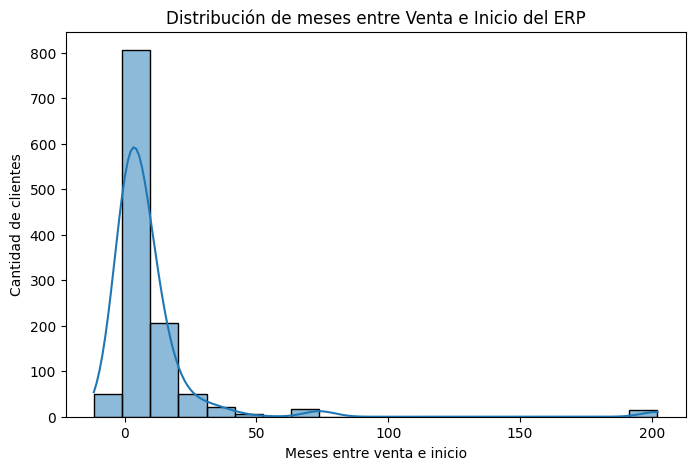

ValueError: Could not interpret value `Fecha de Venta` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir las fechas
fechas_cols = ["Fecha de  Venta", "Fecha de Inicio PalJetERP"]
for col in fechas_cols:
    df_CRM[col] = pd.to_datetime(df_CRM[col], errors="coerce", dayfirst=True)

# Calcular diferencia en días
df_CRM["Dias_Venta_a_Inicio"] = (df_CRM["Fecha de Inicio PalJetERP"] - df_CRM["Fecha de  Venta"]).dt.days

# Pasar a meses (aprox 30 días)
df_CRM["Meses_Venta_a_Inicio"] = df_CRM["Dias_Venta_a_Inicio"] / 30

# Filtrar válidos
df_validos = df_CRM.dropna(subset=["Meses_Venta_a_Inicio"])

# --- Histograma ---
plt.figure(figsize=(8,5))
sns.histplot(df_validos["Meses_Venta_a_Inicio"], bins=20, kde=True)
plt.title("Distribución de meses entre Venta e Inicio del ERP")
plt.xlabel("Meses entre venta e inicio")
plt.ylabel("Cantidad de clientes")
plt.show()

# --- Scatterplot ---
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_validos,
    x="Fecha de Venta",
    y="Meses_Venta_a_Inicio",
    hue="Nombre de Cuenta"
)
plt.title("Tiempo de implementación por cliente (en meses)")
plt.xlabel("Fecha de Venta")
plt.ylabel("Meses hasta inicio")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [20]:
# Agrupar por cliente y consolidar
resumen_x_cliente = (
    df_CRM.groupby("Nombre de Cuenta")
    .agg({
        "Producto": "count",                       # contar la cantidad de productos
        "Cantidad de PC": "first",                   # tomar el valor (asumimos que es el mismo en todas las filas)
        "Fecha de Inicio PalJetERP": "first"         # tomar la primera fecha
    })
    .reset_index()
    .rename(columns={
        "Producto": "Cantidad_Productos",
        "Cantidad de PC": "Cantidad_PC",
        "Fecha de Inicio PalJetERP": "Fecha_Inicio_PalJetERP"
    })
)

print(resumen_x_cliente)
"""
# Exportar a Excel
resumen.to_excel("resumen_clientes.xlsx", index=False)

print("✅ Archivo 'resumen_clientes.xlsx' generado con éxito.")
"""


            Nombre de Cuenta  Cantidad_Productos  Cantidad_PC  \
0          AB CONSTRUCCIONES                  17           89   
1               ACEROS DEFER                   9           16   
2              AGROCOMERCIAL                   3            8   
3    AGROPECUARIA ALMAFUERTE                   4           21   
4                AGRUCOR ACE                   3            0   
..                       ...                 ...          ...   
291    VETERINARIA ARGENTINA                   1            7   
292                 WUIGNIER                   3           14   
293                    YAPUR                  14          108   
294           ZC HERRAMENTAL                   9           14   
295            ÁRIDOS YVYCUI                   2            4   

    Fecha_Inicio_PalJetERP  
0               28/02/2013  
1               02/09/2019  
2               01/02/2021  
3               06/01/2018  
4               29/03/2006  
..                     ...  
291             

'\n# Exportar a Excel\nresumen.to_excel("resumen_clientes.xlsx", index=False)\n\nprint("✅ Archivo \'resumen_clientes.xlsx\' generado con éxito.")\n'

In [21]:
# Hacemos el merge (LEFT o FULL dependiendo de lo que quieras conservar)
tabla_unificada = pd.merge(
    resumen_x_cliente,
    tabla_final, # tickets_por_cliente,
    on="Nombre de Cuenta",
    how="outer"   # "outer" conserva todos los registros de ambos datasets
)

# Rellenar valores NaN en Cantidad_Tickets con 0
"""tabla_unificada["Cantidad_Tickets"] = tabla_unificada["Cantidad_Tickets"].fillna(0).astype(int)"""
tabla_unificada["TOTAL_Tickets"] = tabla_unificada["TOTAL_Tickets"].fillna(0).astype(int)

"""
# Exportar a Excel
tabla_unificada.to_excel("tabla_unificada.xlsx", index=False)

print("✅ Archivo 'tabla_unificada.xlsx' generado con éxito.")
"""

'\n# Exportar a Excel\ntabla_unificada.to_excel("tabla_unificada.xlsx", index=False)\n\nprint("✅ Archivo \'tabla_unificada.xlsx\' generado con éxito.")\n'

# Algunos análisis

## 2️⃣ Relación entre esfuerzo y recursos del cliente

- Tickets vs Cantidad de productos

- ¿Los clientes con más productos generan más tickets?

- Scatterplot: Cantidad_Productos vs Total_Tickets.

- Tickets vs Cantidad de PC

- Analizar si más infraestructura (PCs) implica más soporte.

- Tickets por usuario o por PC

- Métrica de “tickets por recurso”:

In [107]:
tabla_unificada.head()

,Nombre de Cuenta,Cantidad_Productos,Cantidad_PC,Fecha_Inicio_PalJetERP,Cantidad_Tickets 2021,Cantidad_Tickets 2022,Cantidad_Tickets 2023,Cantidad_Tickets 2024,Cantidad_Tickets 2025,TOTAL_Tickets
0,121,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1
1,121 . Customertech,NaN,NaN,NaN,10.0,2.0,1.0,3.0,1.0,17
2,121 Prueba Desestimar,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1
3,AB CONSTRUCCIONES,17.0,89.0,28/02/2013,82.0,141.0,123.0,141.0,137.0,624
4,ACEROS DEFER,9.0,16.0,02/09/2019,106.0,115.0,103.0,55.0,35.0,414


In [108]:
tabla_unificada["Tickets_por_PC"] = tabla_unificada["TOTAL_Tickets"] / tabla_unificada["Cantidad_PC"].replace(0,1)
tabla_unificada


,Nombre de Cuenta,Cantidad_Productos,Cantidad_PC,Fecha_Inicio_PalJetERP,Cantidad_Tickets 2021,Cantidad_Tickets 2022,Cantidad_Tickets 2023,Cantidad_Tickets 2024,Cantidad_Tickets 2025,TOTAL_Tickets,Tickets_por_PC
0,121,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1,NaN
1,121 . Customertech,NaN,NaN,NaN,10.0,2.0,1.0,3.0,1.0,17,NaN
2,121 Prueba Desestimar,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1,NaN
3,AB CONSTRUCCIONES,17.0,89.0,28/02/2013,82.0,141.0,123.0,141.0,137.0,624,7.011236
4,ACEROS DEFER,9.0,16.0,02/09/2019,106.0,115.0,103.0,55.0,35.0,414,25.875000
...,...,...,...,...,...,...,...,...,...,...,...
461,ZC HERRAMENTAL,9.0,14.0,05/01/2021,167.0,47.0,184.0,131.0,100.0,629,44.928571
462,bricoshop,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,1,NaN
463,prueba1,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1,NaN
464,s/r,NaN,NaN,NaN,17.0,14.0,26.0,11.0,18.0,86,NaN


## 📈 ¿Qué vas a obtener?

### Scatterplot Tickets vs Productos

- Cada punto es un cliente.

- Si ves una tendencia ascendente → a más productos, más tickets.

- Si hay mucha dispersión → no está claro, podrías investigar casos.

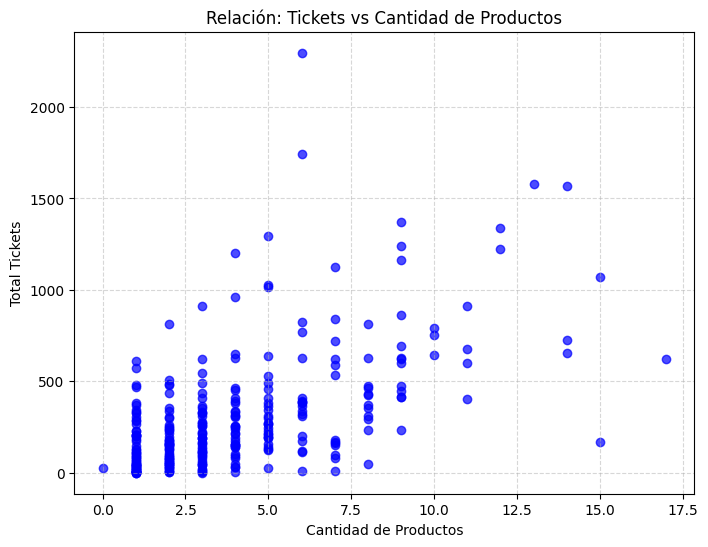

In [111]:
# --- Preparar dataset ---
df = tabla_unificada.copy()  # por si trabajamos sobre el original

# Calcular total de tickets sumando por año
cols_tickets = [c for c in df.columns if "Cantidad_Tickets" in c]
df["Total_Tickets"] = df[cols_tickets].sum(axis=1)

# Evitar división por cero en PCs
df["Cantidad_PC"] = df["Cantidad_PC"].fillna(0)
df["Tickets_por_PC"] = df.apply(
    lambda x: x["Total_Tickets"] / x["Cantidad_PC"] if x["Cantidad_PC"] > 0 else 0, axis=1
)

# --- Gráfico 1: Tickets vs Productos ---
plt.figure(figsize=(8,6))
plt.scatter(df["Cantidad_Productos"], df["Total_Tickets"], alpha=0.7, c="blue")
plt.title("Relación: Tickets vs Cantidad de Productos")
plt.xlabel("Cantidad de Productos")
plt.ylabel("Total Tickets")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



## Scatterplot Tickets vs PCs

- Permite ver si los clientes con más infraestructura generan más soporte.

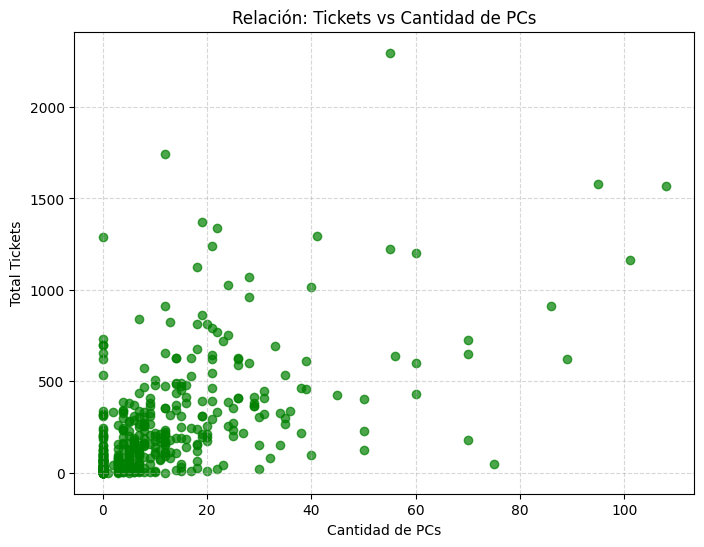

In [112]:
# --- Gráfico 2: Tickets vs PCs ---
plt.figure(figsize=(8,6))
plt.scatter(df["Cantidad_PC"], df["Total_Tickets"], alpha=0.7, c="green")
plt.title("Relación: Tickets vs Cantidad de PCs")
plt.xlabel("Cantidad de PCs")
plt.ylabel("Total Tickets")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



## Histograma Tickets por PC

- Para ver cómo se distribuye la carga relativa de soporte.

- Identifica clientes que son “caros” en soporte en relación a sus PCs.

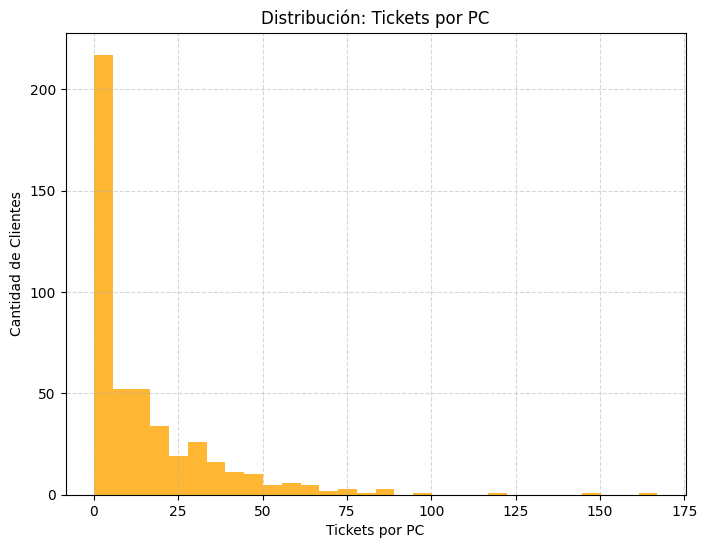

In [113]:
# --- Gráfico 3: Tickets por PC ---
plt.figure(figsize=(8,6))
plt.hist(df["Tickets_por_PC"], bins=30, color="orange", alpha=0.8)
plt.title("Distribución: Tickets por PC")
plt.xlabel("Tickets por PC")
plt.ylabel("Cantidad de Clientes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

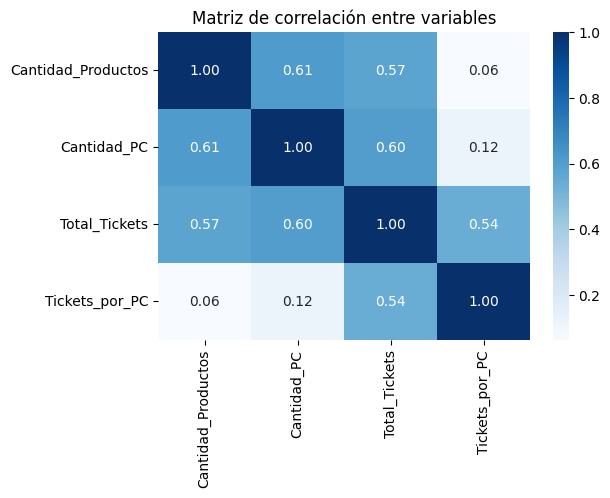

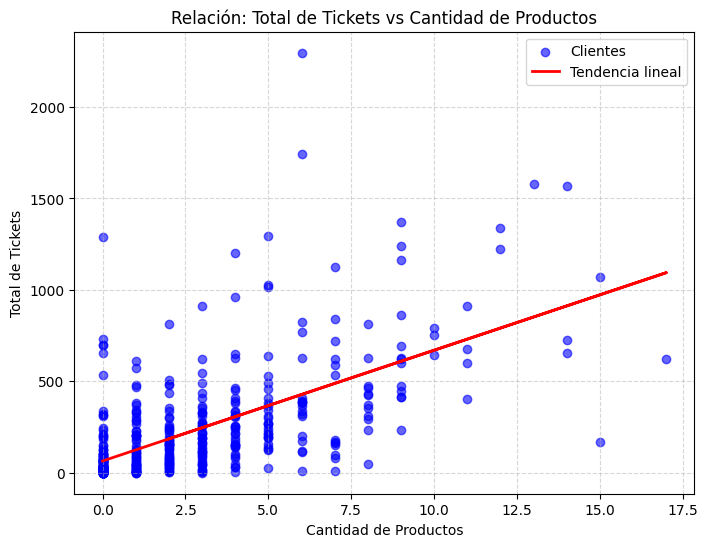

📊 Regresión Total de Tickets ~ Cantidad de Productos
  Pendiente: 60.577
  Intercepto: 64.214
  R²: 0.397



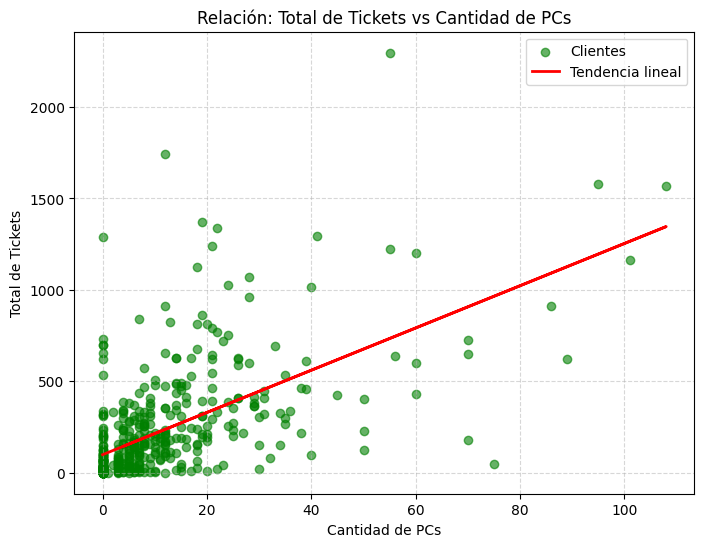

📊 Regresión Total de Tickets ~ Cantidad de PCs
  Pendiente: 11.552
  Intercepto: 98.604
  R²: 0.365



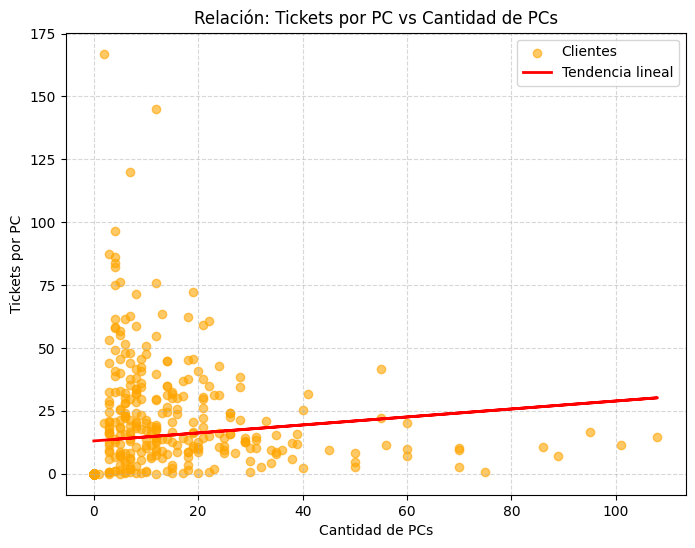

📊 Regresión Tickets por PC ~ Cantidad de PCs
  Pendiente: 0.159
  Intercepto: 13.040
  R²: 0.014



In [115]:
from sklearn.linear_model import LinearRegression


# Calcular total de tickets sumando por año
cols_tickets = [c for c in df.columns if "Cantidad_Tickets" in c]
df["Total_Tickets"] = df[cols_tickets].sum(axis=1)

# Evitar división por cero en PCs
df["Cantidad_PC"] = df["Cantidad_PC"].fillna(0)
df["Tickets_por_PC"] = df.apply(
    lambda x: x["Total_Tickets"] / x["Cantidad_PC"] if x["Cantidad_PC"] > 0 else 0, axis=1
)

# --- Matriz de correlación ---
variables = ["Cantidad_Productos", "Cantidad_PC", "Total_Tickets", "Tickets_por_PC"]
corr = df[variables].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.show()

# --- Función para scatter + regresión lineal ---
def scatter_reg(x, y, xlabel, ylabel, color):
    X = df[[x]].fillna(0).values
    Y = df[y].fillna(0).values
    
    # Ajustar modelo lineal
    model = LinearRegression()
    model.fit(X, Y)
    y_pred = model.predict(X)
    
    # Gráfico
    plt.figure(figsize=(8,6))
    plt.scatter(X, Y, alpha=0.6, c=color, label="Clientes")
    plt.plot(X, y_pred, color="red", linewidth=2, label="Tendencia lineal")
    plt.title(f"Relación: {ylabel} vs {xlabel}")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()
    
    # Coeficientes
    print(f"📊 Regresión {ylabel} ~ {xlabel}")
    print(f"  Pendiente: {model.coef_[0]:.3f}")
    print(f"  Intercepto: {model.intercept_:.3f}")
    print(f"  R²: {model.score(X, Y):.3f}\n")

# --- Gráficos con regresión ---
scatter_reg("Cantidad_Productos", "Total_Tickets", "Cantidad de Productos", "Total de Tickets", "blue")
scatter_reg("Cantidad_PC", "Total_Tickets", "Cantidad de PCs", "Total de Tickets", "green")
scatter_reg("Cantidad_PC", "Tickets_por_PC", "Cantidad de PCs", "Tickets por PC", "orange")

In [22]:
tabla_unificada.head(-2)

,Nombre de Cuenta,Cantidad_Productos,Cantidad_PC,Fecha_Inicio_PalJetERP,Cantidad_Tickets 2021,Cantidad_Tickets 2022,Cantidad_Tickets 2023,Cantidad_Tickets 2024,Cantidad_Tickets 2025,TOTAL_Tickets
0,121,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1
1,121 . Customertech,NaN,NaN,NaN,10.0,2.0,1.0,3.0,1.0,17
2,121 Prueba Desestimar,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1
3,AB CONSTRUCCIONES,17.0,89.0,28/02/2013,82.0,141.0,123.0,141.0,137.0,624
4,ACEROS DEFER,9.0,16.0,02/09/2019,106.0,115.0,103.0,55.0,35.0,414
...,...,...,...,...,...,...,...,...,...,...
459,WUIGNIER,3.0,14.0,01/09/2014,8.0,2.0,6.0,1.0,0.0,17
460,Workok,NaN,NaN,NaN,39.0,41.0,39.0,26.0,5.0,150
461,YAPUR,14.0,108.0,01/03/2009,252.0,331.0,402.0,372.0,211.0,1568
462,ZC HERRAMENTAL,9.0,14.0,05/01/2021,167.0,47.0,184.0,131.0,100.0,629


## VERLO COMPLETO
# 3. Limpieza y preparación de los datos


In [ ]:
# Eliminar duplicados
df = df.drop_duplicates()

# Manejo de valores nulos
df = df.fillna(0)

# Crear métricas derivadas
df["Solicitudes_Total"] = df["Tickets"] + df["Llamadas"]
df["Solicitudes_por_Licencia"] = df["Solicitudes_Total"] / df["Licencias"].replace(0, np.nan)
df["Productos_por_Año"] = df["Productos"] / df["Antiguedad_Anios"].replace(0, np.nan)



In [ ]:
# =====================================================
# 4. ANÁLISIS EXPLORATORIO
# =====================================================

# Estadísticas descriptivas
print("\nEstadísticas generales:")
display(df.describe())

# Distribución de clientes por licencias
plt.figure(figsize=(8,5))
sns.histplot(df["Licencias"], bins=20, kde=True)
plt.title("Distribución de Licencias por Cliente")
plt.show()

# Relación Licencias vs. Tickets
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="Licencias", y="Tickets")
plt.title("Licencias vs Tickets")
plt.show()

# Pareto: clientes que más solicitudes generan
df_pareto = df.sort_values("Solicitudes_Total", ascending=False)
df_pareto["% Acumulado"] = df_pareto["Solicitudes_Total"].cumsum() / df_pareto["Solicitudes_Total"].sum() * 100

fig = px.bar(df_pareto, x="Cliente", y="Solicitudes_Total", title="Pareto de Solicitudes por Cliente")
fig.add_scatter(x=df_pareto["Cliente"], y=df_pareto["% Acumulado"], mode="lines+markers", name="% Acumulado")
fig.show()



In [ ]:
# =====================================================
# 5. SEGMENTACIÓN DE CLIENTES (CLUSTERING)
# =====================================================

# Seleccionar variables para el modelo
vars_modelo = ["Licencias", "Productos", "Solicitudes_Total", "Antiguedad_Anios"]
X = df[vars_modelo]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualización de clusters
fig = px.scatter_3d(df, x="Licencias", y="Productos", z="Solicitudes_Total",
                    color="Cluster", hover_data=["Cliente"])
fig.show()



In [ ]:
# =====================================================
# 6. INSIGHTS INICIALES
# =====================================================
# Agrupar por cluster para ver promedios
insights = df.groupby("Cluster")[vars_modelo].mean()
print("\nPromedios por cluster:")
display(insights)

# Guardar resultados
df.to_csv("clientes_segmentados.csv", index=False)
print("\nArchivo 'clientes_segmentados.csv' generado.")